## Link to Colab

In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading Dependencies

In [2]:
# install torchaudio
!pip install torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
# current torch version is 1.7.0+cu101
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd

In [5]:
# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

cuda


In [6]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/TIL2021/competition/SC/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

## Speech Classification Dataset
We will be providing the base dataset that will be used for the first task of the Speech Classification competition.

In [7]:
!gdown --id 1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
!unzip s1_train_release.zip

Downloading...
From: https://drive.google.com/uc?id=1im5shxcavdoTRNT66mhVdtA_E0ZR8QLl
To: /content/s1_train_release.zip
48.3MB [00:00, 132MB/s]
Archive:  s1_train_release.zip
   creating: s1_train_release/bird/
  inflating: s1_train_release/bird/train_bird_8400.wav  
  inflating: s1_train_release/bird/train_bird_8401.wav  
  inflating: s1_train_release/bird/train_bird_8402.wav  
  inflating: s1_train_release/bird/train_bird_8405.wav  
  inflating: s1_train_release/bird/train_bird_8406.wav  
  inflating: s1_train_release/bird/train_bird_8407.wav  
  inflating: s1_train_release/bird/train_bird_8408.wav  
  inflating: s1_train_release/bird/train_bird_8409.wav  
  inflating: s1_train_release/bird/train_bird_8411.wav  
  inflating: s1_train_release/bird/train_bird_8416.wav  
  inflating: s1_train_release/bird/train_bird_8417.wav  
  inflating: s1_train_release/bird/train_bird_8419.wav  
  inflating: s1_train_release/bird/train_bird_8420.wav  
  inflating: s1_train_release/bird/train_bird_84

In [8]:
class CustomSpeechDataset(torch.utils.data.Dataset):
  def __init__(self, path, typ='train', transforms=None):

    assert typ == 'train' or typ == 'test', 'typ must be either "train" or "test"'

    self.typ = typ
    self.transforms = transforms
    self.targets = []

    if self.typ == 'train':
      self.class_names = sorted(os.listdir(path))
      num_classes = len(self.class_names)

      for class_idx, class_name in enumerate(self.class_names):
        class_dirx = os.path.join(path, class_name)
        wav_list = os.listdir(class_dirx)

        for wav_file in wav_list:
          self.targets.append({
              'filename': wav_file,
              'path': os.path.join(class_dirx, wav_file),
              'class': class_name
          })

    if self.typ == 'test':
      wav_list = os.listdir(path)
      for wav_file in wav_list:
        self.targets.append({
            'filename': wav_file,
            'path': os.path.join(path, wav_file)
        })
  
  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx.tolist()

    # sr is the sampling rate
    signal, sr = torchaudio.load(self.targets[idx]['path'], normalization=True)
    filename = self.targets[idx]['filename']

    if self.transforms:
      for transform in self.transforms:
        signal = transform(signal)

    if self.typ == 'train':
      clx_name = self.targets[idx]['class']
      return filename, signal, sr, clx_name
    
    elif self.typ == 'test':
      return filename, signal, sr

In [26]:
full_dataset = CustomSpeechDataset(path='s1_train_release', typ='train')
train_size = int(len(full_dataset)*0.8)
valid_size = len(full_dataset) - train_size
print(train_size, valid_size)
# train test split
train_set, valid_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

2080 520


In [27]:
labels = full_dataset.class_names
print(labels)

['bird', 'eight', 'falcon', 'five', 'four', 'nine', 'one', 'seven', 'six', 'snake', 'three', 'two', 'zero']


In [28]:
labels_to_indices = {}
for idx, l in enumerate(labels):
  labels_to_indices[l] = idx

In [29]:
print(labels_to_indices)

{'bird': 0, 'eight': 1, 'falcon': 2, 'five': 3, 'four': 4, 'nine': 5, 'one': 6, 'seven': 7, 'six': 8, 'snake': 9, 'three': 10, 'two': 11, 'zero': 12}


## Get the data distribution of each class

In [30]:
train_filename_list = []
train_label_list = []
for i in range(len(train_set)):
    train_filename_list.append(train_set[i][0])
    train_label_list.append(train_set[i][3])
print(train_filename_list[:5])
print(train_label_list[:5])

['train_six_4097.wav', 'train_four_3083.wav', 'train_eight_3226.wav', 'train_one_7289.wav', 'train_bird_8568.wav']
['six', 'four', 'eight', 'one', 'bird']


In [31]:
# make to dataframe
train_tuple = list(zip(train_filename_list, train_label_list))
#print(result_tuple)
train_df = pd.DataFrame(train_tuple, columns=['train_filename', 'train_label'])
train_df.head()

,train_filename,train_label
0,train_six_4097.wav,six
1,train_four_3083.wav,four
2,train_eight_3226.wav,eight
3,train_one_7289.wav,one
4,train_bird_8568.wav,bird


In [32]:
# find the count of each label to check distribution of the labels
train_df["train_label"].value_counts()

four      170
five      167
six       166
falcon    164
eight     163
seven     159
nine      159
zero      157
bird      157
three     157
snake     157
two       154
one       150
Name: train_label, dtype: int64

In [33]:
# Hmmm... The distribution of the data is somehow even for the training set :)

## Let's next look at one example from the training set.

In [34]:
train_set[0]

('train_six_4097.wav',
 tensor([[0.0000e+00, 6.1035e-05, 3.0518e-05,  ..., 1.9440e-02, 1.2054e-02,
          8.5754e-03]]),
 16000,
 'six')

In [35]:
filename, waveform, sample_rate, label_id = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


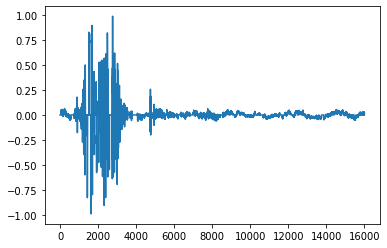

In [36]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Let's plot the waveform using matplotlib
# We observe that the main audio activity happens at the later end of the clip
plt.plot(waveform.t().numpy());

In [37]:
# let's play the audio clip and hear it for ourselves!
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Constant Sample Lengths
In order to insert our features into a model, we have to ensure that the features are of the same size. Below, we see that the sample length varies across the audio clips.

Let's pad the audio clips to a maximum sample length of 16000. (16000 sample length is equal to 1 second at 16,000 Hz sampling rate)
We will pad audio clips which are less than 1 second in length, with parts of itself.

In [54]:
audio_lens = []
for i in range(len(train_set)):
  audio_lens.append(train_set[i][1].size(1))

print('Max Sample Length:', max(audio_lens))
print('Min Sample Length:', min(audio_lens))

Max Sample Length: 16000
Min Sample Length: 16000


Since the min and the max length is the same and hence no need to pad the audio, else can run PadAudio and the shorter ones will be repeated with its own audio

In [79]:
class PadAudio(torch.nn.Module):
  def __init__(self, req_length = 16000):
    super().__init__()
    self.req_length = req_length

  def forward(self, waveform):
    while waveform.size(1) < self.req_length:
      # example if audio length is 15800 and max is 16000, the remaining 200 samples will be concatenated
      # with the FIRST 200 samples of the waveform itself again (repetition)
      waveform = torch.cat((waveform, waveform[:, :self.req_length - waveform.size(1)]), axis=1)
    return waveform

# let's set up a list of transformations we are going to apply to the waveforms
transformations = []
transformations.append(PadAudio())

In [80]:
transformations

[PadAudio()]

## Features
In this classification example, instead of using the raw waveform of the audio clips, we will craft handmade audio features known as melspectrograms instead.

For an in-depth explanation of what a melspectrogram is, I would highly recommend reading this article [here](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53).

In short, a melspectrogram is a way to represent an audio signal’s loudness as it varies over time at different frequencies, while scaled to how humans perceive sound. (We can easily tell the difference between 500 and 1000 Hz, but we can't between 10,000 and 10,500 Hz.)

![pic](https://i.ibb.co/WDsqsfb/melspectrogram.png)


TorchAudio has an in-built method that can help us with this transformation. We shall then apply log scaling.

In [81]:
from torchaudio.transforms import MelSpectrogram

# We define our own log transformation here
class LogMelTransform(torch.nn.Module):

    def __init__(self, log_offset = 1e-6):
        super().__init__()
        self.log_offset = log_offset

    def forward(self, melspectrogram):
        return torch.log(melspectrogram + self.log_offset)

# Let's append these new transformations
transformations.append(MelSpectrogram(sample_rate = 16000, n_mels = 128))
transformations.append(LogMelTransform())

In [82]:
transformations

[PadAudio(), MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ), LogMelTransform()]

## Data Augmentation

We will do a simple data augmentation process in order to increase the variations in our dataset.

In the audio domain, the augmentation technique known as [SpecAugment](https://arxiv.org/abs/1904.08779) is often used. It makes use of 3 steps:
- Time Warp (warps the spectrogram to the left or right) 2nd row
- Frequency Masking (randomly masks a range of frequencies) 3rd row
- Time Masking (randomly masks a range of time) 4th row

![specaugment pic](https://drive.google.com/uc?export=view&id=1C085-PlXVhjzh4kzCy869VHRGwC3aDHJ)

As Time Warp is computationally intensive and does not contribute significant improvement in results, we shall simply use Frequency and Time Masking in this example.

In [83]:
from torchaudio.transforms import TimeMasking, FrequencyMasking

eval_transformations = transformations.copy()

# Let's extend the list of transformations with the augmentations
transformations.append(TimeMasking(time_mask_param = 5)) # a maximum of 10 time steps will be masked
transformations.append(FrequencyMasking(freq_mask_param = 3)) # maximum of 3 freq channels will be masked

In [84]:
print(transformations)

[PadAudio(), MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
), LogMelTransform(), TimeMasking(), FrequencyMasking()]


## Data Loaders

Let's now set up our data loaders so that we can streamline the batch loading of data for our model training later on. 

In [85]:
BATCH_SIZE = 64
NUM_WORKERS = 4
PIN_MEMORY = True if device == 'cuda' else False

def train_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)

    return (tensors, targets, filenames)

def eval_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate, label

    tensors, targets, filenames = [], [], []

    # Gather in lists, and encode labels as indices
    for filename, waveform, sample_rate, label in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        targets += [labels_to_indices[label]]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.LongTensor(targets)
    filenames += [filename]

    return (tensors, targets, filenames)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    collate_fn=train_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=eval_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

## Setting up the Model

In this speech classification example, we will make use of a Long-Short-Term Memory Recurrent Neural Network (LSTM-RNN).

In [86]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index

In [87]:
# initialize the model class
model = RNN(input_size=128, hidden_size=256, num_layers=2, num_classes=len(labels), device=device, classes=labels).to(device)

## Training the model

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer.zero_grad()
num_epochs = 50

In [89]:
for epoch in range(1,num_epochs+1):

  # training steps
  model.train()
  count_correct, count_total = 0, 0
  for idx, (features, targets, filenames) in enumerate(train_loader):

    features = features.to(device)
    targets = targets.to(device)

    # forward pass
    outputs = model(features)
    loss = criterion(outputs, targets)

    # backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # training results
    _, argmax = torch.max(outputs, 1)
    count_correct += (targets == argmax.squeeze()).sum().item()
    count_total += targets.size(0)

  train_acc = count_correct / count_total
  
  # evaluation steps
  model.eval()
  count_correct, count_total = 0, 0
  with torch.no_grad():
    for idx, (features, targets, filenames) in enumerate(valid_loader):

      features = features.to(device)
      targets = targets.to(device)

      # forward pass
      val_outputs = model(features)
      val_loss = criterion(val_outputs, targets)

      # validation results
      _, argmax = torch.max(val_outputs, 1)
      count_correct += (targets == argmax.squeeze()).sum().item()
      count_total += targets.size(0)

  # print results
  valid_acc = count_correct / count_total
  print('Epoch [{}/{}], Train loss = {:.4f}, Train accuracy = {:.2f}, Valid loss = {:.4f}, Valid accuracy = {:.2f}' 
        .format(epoch, num_epochs, loss.item(), 100*train_acc, val_loss.item(), 100*valid_acc))

Epoch [1/50], Train loss = 2.5242, Train accuracy = 10.96, Valid loss = 2.5223, Valid accuracy = 15.58
Epoch [2/50], Train loss = 2.4441, Train accuracy = 17.55, Valid loss = 2.3681, Valid accuracy = 18.85
Epoch [3/50], Train loss = 2.1793, Train accuracy = 22.84, Valid loss = 2.3585, Valid accuracy = 26.73
Epoch [4/50], Train loss = 1.8610, Train accuracy = 30.24, Valid loss = 2.1220, Valid accuracy = 32.31
Epoch [5/50], Train loss = 1.7677, Train accuracy = 40.00, Valid loss = 1.8934, Valid accuracy = 42.88
Epoch [6/50], Train loss = 1.5900, Train accuracy = 46.30, Valid loss = 1.7451, Valid accuracy = 46.54
Epoch [7/50], Train loss = 1.5098, Train accuracy = 51.39, Valid loss = 1.4225, Valid accuracy = 51.15
Epoch [8/50], Train loss = 1.5060, Train accuracy = 55.38, Valid loss = 1.4686, Valid accuracy = 51.35
Epoch [9/50], Train loss = 1.2426, Train accuracy = 56.15, Valid loss = 1.3416, Valid accuracy = 55.00
Epoch [10/50], Train loss = 0.9221, Train accuracy = 59.81, Valid loss = 

In [90]:
# save the model
torch.save(model.state_dict(), f'{COLAB_FILEPATH}model/speech_classification_lstm.pt')

## Load back the model

In [91]:
##model = RNN(input_size=128, hidden_size=128, num_layers=2, num_classes=len(labels), device=device, classes=labels).to(device)
model.load_state_dict(torch.load(f'{COLAB_FILEPATH}model/speech_classification_lstm.pt'))

<All keys matched successfully>

## Test Set

In [92]:
!gdown --id 1AvP49xengGjnFTG209AgvAGj-by8WGSi
!unzip -q -o s1_test.zip

Downloading...
From: https://drive.google.com/uc?id=1AvP49xengGjnFTG209AgvAGj-by8WGSi
To: /content/s1_test.zip
12.3MB [00:00, 57.5MB/s]


In [93]:
# Initialise dataset object for test set
test_set = CustomSpeechDataset(path='s1_test', typ='test')

In [94]:
# define test collate function and set up test loader

def test_collate_fn(batch):

    # A data tuple has the form:
    # filename, waveform, sample_rate

    tensors, filenames = [], []

    # Gather in lists
    for filename, waveform, sample_rate in batch:
        # apply transformations
        for transform in eval_transformations:
            waveform = transform(waveform)
        waveform = waveform.squeeze().T
        tensors += [waveform]
        filenames += [filename]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)

    return (tensors, filenames)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=test_collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

In [95]:
# pass test set through the RNN model
model.eval()
pred_list, filename_list = [], []
with torch.no_grad():
  for idx, (features, filenames) in enumerate(test_loader):

    features = features.to(device)

    # forward pass
    outputs = model(features)

    # test results
    _, argmax = torch.max(outputs, 1)
    pred_list += argmax.cpu().tolist()
    filename_list += filenames

In [96]:
print(pred_list[:5], filename_list[:5])

[11, 8, 7, 2, 6] ['test_1166.wav', 'test_0762.wav', 'test_0598.wav', 'test_1255.wav', 'test_0805.wav']


In [97]:
print(filename_list)

['test_1166.wav', 'test_0762.wav', 'test_0598.wav', 'test_1255.wav', 'test_0805.wav', 'test_1153.wav', 'test_1011.wav', 'test_0517.wav', 'test_1272.wav', 'test_0667.wav', 'test_0395.wav', 'test_0187.wav', 'test_0206.wav', 'test_0157.wav', 'test_0501.wav', 'test_0064.wav', 'test_0393.wav', 'test_0919.wav', 'test_0960.wav', 'test_0770.wav', 'test_0744.wav', 'test_1202.wav', 'test_0125.wav', 'test_1149.wav', 'test_1220.wav', 'test_0664.wav', 'test_0340.wav', 'test_1167.wav', 'test_0645.wav', 'test_0361.wav', 'test_0641.wav', 'test_0632.wav', 'test_0466.wav', 'test_0328.wav', 'test_0721.wav', 'test_0563.wav', 'test_0143.wav', 'test_0927.wav', 'test_0445.wav', 'test_0863.wav', 'test_0471.wav', 'test_1217.wav', 'test_1145.wav', 'test_0733.wav', 'test_0859.wav', 'test_0532.wav', 'test_0000.wav', 'test_0417.wav', 'test_0993.wav', 'test_0474.wav', 'test_0979.wav', 'test_0655.wav', 'test_0057.wav', 'test_1102.wav', 'test_0769.wav', 'test_0018.wav', 'test_0587.wav', 'test_0468.wav', 'test_0886.wa

In [98]:
print(full_dataset.class_names)

['bird', 'eight', 'falcon', 'five', 'four', 'nine', 'one', 'seven', 'six', 'snake', 'three', 'two', 'zero']


## Submission of Results
Submission csv file should contain only 2 columns for filename and label, in that order. The file should be sorted by filename, and exclude headers. 

Refer to **sample_submission.csv** for an example.

In [99]:
result_tuple = list(zip(filename_list, pred_list))
#print(result_tuple)
submission = pd.DataFrame(result_tuple, columns=['filename', 'pred'])
submission = submission.sort_values('filename').reset_index(drop=True)
submission['label'] = submission['pred'].apply(lambda x: labels[x])

In [100]:
submission[['filename', 'label']].head()

,filename,label
0,test_0000.wav,seven
1,test_0004.wav,two
2,test_0005.wav,three
3,test_0006.wav,one
4,test_0007.wav,snake


In [101]:
submission["label"].value_counts()

falcon    59
bird      58
four      57
one       54
two       54
snake     51
seven     51
eight     50
zero      45
three     45
nine      43
six       42
five      40
Name: label, dtype: int64

In [102]:
submission[['filename', 'label']].to_csv(f'{COLAB_FILEPATH}submission/submission.csv', header=None, index=None)